# Walmart Weekly Sales Prediction: A Data Science Showcase

## Imporing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split,GridSearchCV,KFold,cross_val_score,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler,LabelBinarizer,OneHotEncoder,OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.decomposition import FastICA,PCA, TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from scipy import stats
import time
import warnings
warnings.filterwarnings('ignore')

## Loading Data

In [2]:
df=pd.read_csv('master.csv')
df.head()

,Store,Dept,Date,Year,Month,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2/5/2010,2010,2,24924.50,0,A,151315,5.727778,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106
1,1,2,2/5/2010,2010,2,50605.27,0,A,151315,5.727778,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106
2,1,3,2/5/2010,2010,2,13740.12,0,A,151315,5.727778,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106
3,1,4,2/5/2010,2010,2,39954.04,0,A,151315,5.727778,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106
4,1,5,2/5/2010,2010,2,32229.38,0,A,151315,5.727778,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Year          421570 non-null  int64  
 4   Month         421570 non-null  int64  
 5   Weekly_Sales  421570 non-null  float64
 6   IsHoliday     421570 non-null  int64  
 7   Type          421570 non-null  object 
 8   Size          421570 non-null  int64  
 9   Temperature   421570 non-null  float64
 10  Fuel_Price    421570 non-null  float64
 11  MarkDown1     421570 non-null  float64
 12  MarkDown2     421570 non-null  float64
 13  MarkDown3     421570 non-null  float64
 14  MarkDown4     421570 non-null  float64
 15  MarkDown5     421570 non-null  float64
 16  CPI           421570 non-null  float64
 17  Unemployment  421570 non-null  float64
dtypes: f

## Final Data Preprocessing

In [4]:
# Create a copy of the DataFrame 'df' to avoid modifying the original DataFrame.
df_copy= df.copy()

# Converting selected columns to 'object' data type for treating them as categorical variables.
df_copy['Store']=df_copy.Store.astype('object')
df_copy['Dept']=df_copy.Dept.astype('object')
df_copy['Date']=pd.to_datetime(df_copy.Date)
df_copy['Month']=df_copy.Month.astype('object')
df_copy['Year']=df_copy.Year.astype('int64')

In [5]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  object        
 1   Dept          421570 non-null  object        
 2   Date          421570 non-null  datetime64[ns]
 3   Year          421570 non-null  int64         
 4   Month         421570 non-null  object        
 5   Weekly_Sales  421570 non-null  float64       
 6   IsHoliday     421570 non-null  int64         
 7   Type          421570 non-null  object        
 8   Size          421570 non-null  int64         
 9   Temperature   421570 non-null  float64       
 10  Fuel_Price    421570 non-null  float64       
 11  MarkDown1     421570 non-null  float64       
 12  MarkDown2     421570 non-null  float64       
 13  MarkDown3     421570 non-null  float64       
 14  MarkDown4     421570 non-null  float64       
 15  MarkDown5     421

## Feature Selection using OrdinalEncoder
One of OneHot Encoder's breakdowns, that its generate a large number of sub features or columns making feature selection even harder, in below experiment we will rerun feature selection trial with OrdinalEncoder as it expect to generate less number of features or columns.

In [6]:
# Filter the data for the training set (February 2010 to March 2012)
train_start_date = '2010-02-01'
train_end_date = '2012-03-31'
train_mask = (df_copy['Date'] >= train_start_date) & (df_copy['Date'] <= train_end_date)
X_train = df_copy[train_mask].drop(columns=['Date', 'Weekly_Sales'])
y_train = df_copy[train_mask]['Weekly_Sales']

# Filter the data for the test set (April 2012 to October 2012)
test_start_date = '2012-04-01'
test_end_date = '2012-10-31'
test_mask = (df_copy['Date'] >= test_start_date) & (df_copy['Date'] <= test_end_date)
X_test = df_copy[test_mask].drop(columns=['Date', 'Weekly_Sales'])
y_test = df_copy[test_mask]['Weekly_Sales']

In [7]:
# Create an instance of the OrdinalEncoder class, which is used for encoding categorical features into numerical values.
model_incoder = OrdinalEncoder()

# Fit the OrdinalEncoder on the feature matrix X. This step determines the mapping of categories to numeric values.
model_incoder.fit(df_copy.drop(columns=['Date', 'Weekly_Sales']))

# Transform (encode) the original feature matrix X into a new matrix x_trans where categorical values are represented as numeric values.
X_train_trans = model_incoder.transform(X_train)
X_test_trans = model_incoder.transform(X_test)


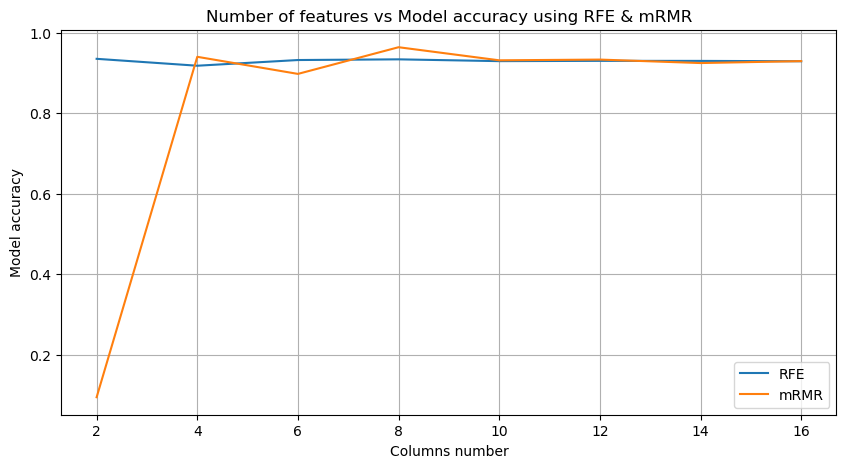

In [8]:
def run_model_MRMR(k):
    '''
    Peform feature selection using the mRMR method, given a certain number of columns.
    The function will append model accuracy with the result array
    '''
    global X_train_trans
    global X_test_trans
    slct_best = SelectKBest(k=k, score_func=f_regression)
    slct_best = slct_best.fit(X_train_trans, y_train)
    X_train_trans_ = slct_best.transform(X_train_trans)
    X_test_trans_ = slct_best.transform(X_test_trans)
    model = Model()
    model.fit(X_train_trans_, y_train)
    predictions = model.predict(X_test_trans_)
    r2 = r2_score(y_test, predictions)
    result.append({'k': k, 'MRMR R2': r2})

def run_model_greedy(k):
    '''
    Peform feature selection using the RFE method, given a certain number of columns.
    The function will append model accuracy with the result array
    '''
    global X_train_trans
    global X_test_trans
    model = Model()
    rfe = RFE(model,n_features_to_select = k)
    rfe = rfe.fit(X_train_trans,y_train)
    X_train_trans_ = rfe.transform(X_train_trans)
    X_test_trans_ = rfe.transform(X_test_trans)
    model = Model()
    model.fit(X_train_trans_,y_train)
    predictions = model.predict(X_test_trans_)
    return r2_score(y_test,predictions)

Model = DecisionTreeRegressor
result = []
for k in range(2,len(X_test.columns)+1,2):
    run_model_MRMR(k)

result = pd.DataFrame(result)
result_greedy = []
for k in result['k']:
    result_greedy.append(run_model_greedy(k))
result['greedy'] = result_greedy
ax = plt.figure(figsize=(10,5))
plt.plot(result['k'],result['greedy'], label = 'RFE')
plt.plot(result['k'],result['MRMR R2'], label = 'mRMR')
plt.legend()
plt.title('Number of features vs Model accuracy using RFE & mRMR')
plt.xlabel('Columns number')
plt.ylabel('Model accuracy')
plt.grid()
plt.show()

### Result

From above figure we can conclude below two points:

   1 - The larger columns selected the greater model accuruacy is, since model accurucy is increased when increasing the feature number we decide to include all features in the model.
   
   2 - Using OrdinalEncoding actually leads for similar accurucay as encoding the model with OneHot technique, as a result we decise to use OrdinalEncoding in our model since it will lead for same model accurucy and require less computing time due to final number of features is 16 instead of 153!

## Model Selection

The purpose here is to automate the training and evaluation of machine learning models for predicting weekly sales at Walmart stores. It involves defining functions for training and evaluating models. The train_model function pre-processes data, combines preprocessing and modeling steps into a pipeline, measures training time, and returns the trained model. The evaluate_model function calculates key performance metrics like MAE, RMSE, and R-squared for model assessment.

Various models, including Linear Regression, Ridge Regression, Lasso Regression, Decision Tree Regressor, and Random Forest Regressor, are defined and trained. Data is split into training and testing sets, models are trained and evaluated on the test data, and results are printed. This automation streamlines model comparison, aiding in the selection of the best model for predicting Walmart's weekly sales.

In [9]:
def train_model(model, X_train, y_train):
    """
    Train a machine learning model with data preprocessing using a pipeline.

    Parameters:
    - model: The machine learning model to be trained.
    - X_train: The training features.
    - y_train: The training target values.

    Returns:
    - trained_model: A trained model wrapped in a pipeline, including preprocessing steps.

    This function takes a machine learning model, training features (X_train), and training target values (y_train).
    It performs the following steps:
    1. Preprocesses the data by applying one-hot encoding to categorical columns and scaling numerical columns.
    2. Combines the preprocessing transformers into a pipeline along with the specified model.
    3. Fits the pipeline on the training data.
    4. Measures the training time and prints it.

    The trained model, including preprocessing steps, is returned for further use.
    """
    # Extract and categorize the column data types into categorical and numerical for further preprocessing.
    data_types = X_train.dtypes
    categorical_columns = data_types[data_types == 'object'].index.tolist()
    numerical_columns = data_types[data_types != 'object'].index.tolist()

    # Create transformers for preprocessing categorical and numerical columns
    categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(sparse_output=False))])
    numerical_transformer = Pipeline(steps=[('scaler', StandardScaler())])

    # Combine transformers for both types of columns
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', categorical_transformer, categorical_columns),
            ('num', numerical_transformer, numerical_columns)
        ], remainder='passthrough')


    #Create the final pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    # Record the start time to measure the training duration of the machine learning pipeline.
    start_time = time.time()

    # Fit the machine learning pipeline on the training data, measure the training time, and print the duration.
    pipeline.fit(X_train, y_train)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Training time for {model}: {elapsed_time:.4f} seconds")


    return pipeline

# Function to evaluate a model
def evaluate_model(model, X_test, y_test):
    """
        Evaluate a machine learning model on a test dataset.

        Parameters:
        - model: The trained machine learning model to be evaluated.
        - X_test: The test features.
        - y_test: The true target values for the test dataset.

        Returns:
        - evaluation_results: A dictionary containing evaluation metrics, including MAE, MSE, and R-squared.

        This function takes a trained machine learning model, test features (X_test), and true target values (y_test).
        It performs the following steps:
        1. Uses the trained model to make predictions on the test features.
        2. Calculates Mean Absolute Error (MAE), Mean Squared Error (MSE), and R-squared (R2) between the predicted
           values and true target values.
        3. Returns a dictionary containing the computed evaluation metrics.

         The evaluation results provide insights into the model's performance on the test dataset.
    """
    # Use the trained model to make predictions on the test data.
    # Then calculate and return evaluation metrics including MAE, RMSE, and R-squared.
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred,squared=False)
    r2 = r2_score(y_test, y_pred)

    return {"MAE": mae, "RMSE": rmse, "R-squared": r2}

# Define your models
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=10),
    'Lasso': Lasso(alpha=10),
    'DecisionTree': DecisionTreeRegressor(),
    'RandomForest':RandomForestRegressor(n_estimators=10)
}


# Train the models and store them in a dictionary
trained_models = {}
for model_name, model in models.items():
    trained_models[model_name] = train_model(model, X_train, y_train)


# Evaluate the models and store the results in a dictionary
results = {}
for model_name, model in trained_models.items():
    results[model_name] = evaluate_model(model,X_test, y_test)

# Print the results
for model_name, metrics in results.items():
    print(f"\nModel: {model_name}")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")
    print('\n')

Training time for LinearRegression(): 6.7537 seconds
Training time for Ridge(alpha=10): 1.5445 seconds
Training time for Lasso(alpha=10): 24.7028 seconds
Training time for DecisionTreeRegressor(): 37.3358 seconds
Training time for RandomForestRegressor(n_estimators=10): 210.1298 seconds

Model: LinearRegression
MAE: 7987.7437
RMSE: 12235.5764
R-squared: 0.6926



Model: Ridge
MAE: 7979.8804
RMSE: 12231.8539
R-squared: 0.6928



Model: Lasso
MAE: 7914.7157
RMSE: 12268.2787
R-squared: 0.6910



Model: DecisionTree
MAE: 2505.8210
RMSE: 5352.5212
R-squared: 0.9412



Model: RandomForest
MAE: 1975.9104
RMSE: 4100.5899
R-squared: 0.9655




The decision to choose the Decision Tree model over the other options is based on several factors:

1. **Excellent Predictive Performance**: The Decision Tree model exhibits outstanding predictive performance, as indicated by its low Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and high R-squared value. These metrics collectively suggest that the model captures and explains a significant portion of the variance in the data, resulting in accurate sales predictions.

2. **Faster Training Time**: The Decision Tree model boasts a relatively shorter training time compared to the Random Forest model. While it takes significantly less time to train, it still delivers competitive predictive performance, making it a practical choice for large datasets or scenarios where model training time is a concern.

3. **Low Complexity**: Decision Trees have a straightforward structure with a hierarchy of decisions based on features, making them less complex than ensemble methods like Random Forests. This simplicity can reduce the risk of overfitting.

4. **Applicability**: Decision Trees are versatile and can be easily adapted to handle various types of features and datasets. Their ability to handle both categorical and numerical data makes them suitable for a wide range of applications, including sales prediction for Walmart stores.

## Hyperparameters Tuning

In [10]:
# Define a parameter grid for hyperparameter tuning
param_grid = {
    'criterion': ['squared_error','friedman_mse'],  # Valid criteria for regression
    'max_depth': [None, 105],  # Maximum depth of the tree
    'min_samples_split': [2, 30]  # Minimum samples required to split an internal node
}

In [11]:
# Initialize an OrdinalEncoder for categorical feature encoding.
encoder = OrdinalEncoder()

# Initialize a DecisionTreeRegressor model.
model = DecisionTreeRegressor()

# Fit the OrdinalEncoder on the training data after excluding non-numeric columns.
encoder.fit(df_copy.drop(columns=['Date', 'Weekly_Sales']))

# Transform the training features using the fitted encoder.
X_trans = encoder.transform(X_train)

In [12]:
# Hyperparameter tuning using GridSearchCV.
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)

# Execute the hyperparameter search.
grid_search.fit(X_trans, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'criterion': ['squared_error', 'friedman_mse'],
                         'max_depth': [None, 105],
                         'min_samples_split': [2, 30]},
             scoring='neg_mean_squared_error')

In [13]:
# Serialize and save the trained model (grid_search) using Pickle to a file named 'model.pkl'.
import pickle
pickle.dump(grid_search, open('model.pkl', 'wb'))

## Model Evaluation

In [14]:
# Retrieve the best estimator (model with optimal hyperparameters) from the GridSearchCV.
grid_search.best_estimator_

DecisionTreeRegressor(max_depth=105, min_samples_split=30)

In [15]:
# Get the best hyperparameters selected by GridSearchCV.
grid_search.best_params_

{'criterion': 'squared_error', 'max_depth': 105, 'min_samples_split': 30}

In [16]:
# Retrieve the best negative mean squared error score achieved during hyperparameter tuning.
grid_search.best_score_

-190056317.24674505

In [17]:
# Make predictions using the best estimator from GridSearchCV and calculate the R-squared score on the test data.
X_test_trans = encoder.transform(X_test)
y_pred = grid_search.predict(X_test_trans)
r2_score(y_test,y_pred)

0.9419780940962633

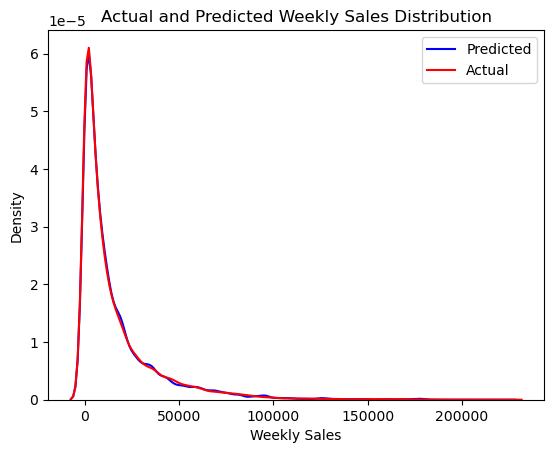

In [18]:
# Create Kernel Density Estimation (KDE) plot for model predictions (y_pred).
sns.kdeplot(y_pred,color='b',label='Predicted')

# Create a separate KDE plot for actual target values (y_test).
sns.kdeplot(y_test,color='r',label='Actual')

plt.legend()
plt.xlabel('Weekly Sales')
plt.title('Actual and Predicted Weekly Sales Distribution')
plt.show()

KDE plots visually assess predictive model performance by comparing its distribution to actual data. They offer a rapid evaluation of alignment and accuracy, aiding in understanding how well the model captures underlying patterns.

## Feature Importance

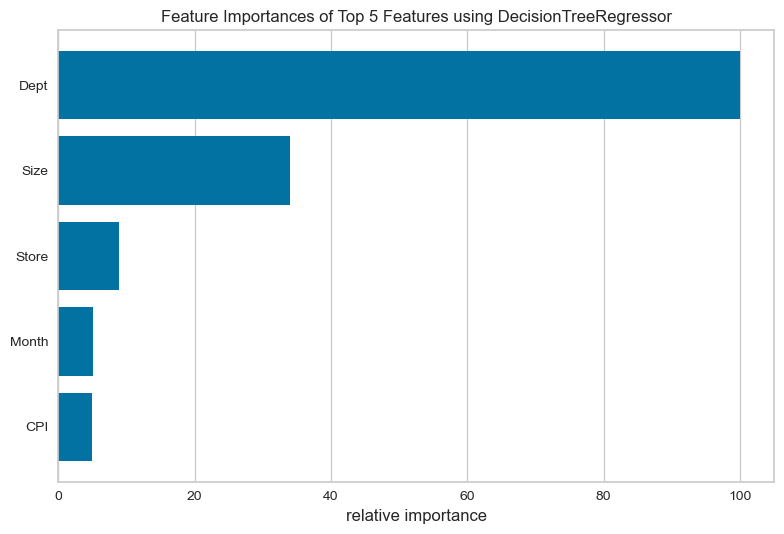

In [20]:
from yellowbrick.model_selection import FeatureImportances

# Create a FeatureImportances visualization using the Yellowbrick library to assess feature importance.
viz = FeatureImportances(grid_search.estimator, labels=X_train.columns.values, topn=5, colors='b')

# Fit the visualization to the training data and the target variable.
viz.fit(X_trans, y_train)

# Show the visualization
viz.show()
plt.show()

## SARIMA Model

**ARIMA** (AutoRegressive Integrated Moving Average):

- ARIMA is a popular time series forecasting method. It stands for AutoRegressive Integrated Moving Average. ARIMA models are suitable for stationary time series data and consist of three main components: AutoRegressive (AR), Integrated (I), and Moving Average (MA).

**SARIMA** (Seasonal AutoRegressive Integrated Moving Average):

- SARIMA extends ARIMA by incorporating seasonality. It includes seasonal AutoRegressive (SAR), Integrated (SI), and Moving Average (SMA) components in addition to the non-seasonal ones.

**Difference between ARIMA and SARIMA**:

- The primary distinction is that ARIMA handles non-seasonal data, while SARIMA explicitly models and accounts for seasonality in time series data using additional seasonal parameters (P, D, Q).

**Forecast Bias**:

- Forecast bias refers to a consistent tendency in a forecasting model to either overestimate (positive bias) or underestimate (negative bias) actual values. In simpler terms, it means the model consistently gets predictions either too high or too low.

- Understanding forecast bias is essential because it affects decision-making and resource allocation. Overcoming bias involves refining the model, adjusting parameters, or improving data quality to make forecasts more accurate. Monitoring bias helps maintain forecast reliability.

In [21]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
df_copy.Date= pd.to_datetime(df_copy.Date)
df_time_series= df_copy[['Date','Store','Weekly_Sales']]
df_time_series.to_csv('time_series.csv',index=False)

In [22]:
def forecast (*,DataFrame,Store,Month,Year):
    """
    Perform SARIMA time series forecasting for a specific store's weekly sales.
    The model will forecast results between 2012-05-18 and 2014-01-03. If an inserted date was before 2012-05-18,
    the function's average weekly sales result will be historical and not forecasted.

    Parameters:
    - DataFrame (pd.DataFrame): The input DataFrame containing store data.
    - Store (int): The store identifier for which forecasting is performed.
    - Month (int): The target month for which sales forecasting is desired.
    - Year (int): The target year for which sales forecasting is desired.

    Returns:
    float: The mean of weekly sales for the specified Month and Year.

    This function filters the input DataFrame to select data for the specified store,
    calculates the mean weekly sales, and then uses a SARIMA model to forecast sales for
    a specified period into the future. It prints the mean weekly sales for the specified
    month and year, the R-squared score, and visualizes the results. If no forecasted
    values are available for the specified month and year, it falls back to using the
    training data and prints a message.
    """
     # Filter data for the specified store
    df_forecast= DataFrame[(DataFrame.Store==Store) ]
    
    # Calculate the mean weekly sales by grouping data by date
    ts=df_forecast.groupby('Date')['Weekly_Sales'].mean()

    # Split data into training and test sets
    ts_train= ts.head(120)
    ts_test= ts.tail(23)
    
    # Define SARIMA model parameters
    order = (1, 1, 1) 
    seasonal_order = (1, 1, 1, 52)

    # Create and fit the SARIMA model to training data
    sarima_model = SARIMAX(ts_train, order=order, seasonal_order=seasonal_order)
    sarima_results = sarima_model.fit()

    # Specify the forecast period
    forecast_period = 85
    
    # Generate forecasts for the specified period
    forecast = sarima_results.get_forecast(steps=forecast_period)
    forecasted_values=forecast.predicted_mean
    
    # Filter forecasted values for the specified Month and Year
    filtered=forecasted_values[(forecasted_values.index.year==Year) & (forecasted_values.index.month==Month)]
    
    # If no forecasted values are available, use training data and print a message
    if filtered.empty:
        filtered = ts_train[(ts_train.index.year==Year) & (ts_train.index.month==Month)]
        print('Obsereved Values Not Forecasted')
    
    # Calculate R-squared score between observed and predicted sales
    forecast_conf_int = forecast.conf_int()
    ts_pred=[]
    for i in ts_test.index:
        ts_pred.append(sarima_results.predict(pd.Timestamp(i)))
    ts_pred=np.array(ts_pred)

    # Checking Forecast Bias
    # Check if the bias is significantly different from zero using a t-test 
    # You can perform a hypothesis test to determine statistical significance.
    # A bias close to zero indicates that the model's forecasts are, on average, accurate.
    forecast_errors = ts_test.to_numpy().reshape(ts_test.shape[0],1) - ts_pred
    bias= np.mean(forecast_errors)
    t_stat, p_value = stats.ttest_1samp(forecast_errors, 0)
    
    if p_value < 0.05:  # Choose an appropriate significance level (e.g., 0.05)
        print("The forecast has a significant bias.")
    else:
        print("The forecast does not have a significant bias.")
        
    # Print the mean Weekly sales for the specified Month and Year
    print('\n')
    print(f'The mean Weekly sales for month {Month} and year {Year} is {filtered.mean():.2f}$')
    print(f'The R-Squared for Test set is equal to {r2_score(ts_test,ts_pred):.3f}')
    
   
    # Visualize the results using Matplotlib
    plt.figure(figsize=(12, 6))
    plt.plot(ts, label='Observed')
    plt.plot(forecast.predicted_mean, label='Forecast', color='red')
    plt.fill_between(forecast_conf_int.index, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='pink')
    plt.axvline(ts_train.tail(1).index,color='orange')
    plt.title('SARIMA Forecast for Store {}'.format(Store))
    plt.ylabel('Aaverage Weekly Sales (Dollars)')
    plt.xlabel('Date')
    plt.legend()
    
    plt.show()

    
    
    
    # Return the mean of the filtered forecasted values
    return filtered.mean()

In [ ]:
forcasted=forecast(DataFrame=df_copy,Store=5,Month=1,Year=2013)

C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


### Sales Forecast Summary

The `forecast` function is used to perform time series forecasting for a specific store's weekly sales data. It utilizes the SARIMA (Seasonal Autoregressive Integrated Moving Average) model to generate forecasts and provide insights into the sales data. Here's a high-level summary of the process:

1. Data is filtered to select information for the specified store.
2. Mean weekly sales are calculated based on date grouping.
3. The data is split into a training set and a test set.
4. SARIMA model parameters are defined and the model is fitted to the training data.
5. Forecasts are generated for a specified future period.
6. Forecasted values are filtered based on the desired month and year.
7. If no forecasted values are available, observed values from the training data are used.
8. The mean weekly sales for the specified month and year are calculated and printed.
9. The R-squared score between observed and predicted sales is displayed.
10. A visualization shows observed and forecasted sales data.

Additional Bias Checking (Model Evaluation):
- After forecasting, the function checks for forecast bias by calculating forecast errors and performing a hypothesis test to determine statistical significance.
- A bias close to zero indicates that the model's forecasts are, on average, accurate.
- If a significant bias is detected, it indicates that the model may consistently overestimate or underestimate sales values.


This process provides valuable insights into future sales trends for a specific store.